<h1><center>Exploratory Data Analysis</center></h1>
<h5><center>Tiny Shakespeare Dataset</center></h5>

<div class="alert alert-block alert-info">It's a simple EDA of tiny-shakespeare dataset. Here one can find information about:
    <ul>
        <li>distribution of words/characters in each replica</li>
        <li>what is the average, min and max length of replicas</li>
        <li>who is the most common acting person </li>
        <li>what acting person has the largest number of replicas.</li>
    </ul>
</div>

In [1]:
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from src import config

In [2]:
# set styling for charts
plt.style.use("dark_background")  # or "bmh" for light background
plt.rcParams.update({"axes.grid": True})

# 1. Parsing dataset

Tiny-shakespeare dataset is provided in a form of a simple txt file. First we need to parse it.

In [3]:
dataset_filepath = Path("../..").resolve() / config.datasets.tiny_shakespeare.file_path

Let's take a look at how the file is structured:

In [4]:
with open(dataset_filepath, "r") as fin:
    dataset = fin.readlines(100)  # read first 100 bytes

dataset

['First Citizen:\n',
 'Before we proceed any further, hear me speak.\n',
 '\n',
 'All:\n',
 'Speak, speak.\n',
 '\n',
 'First Citizen:\n',
 'You are all resolved rather to die than to famish?\n']

From the output above we can conclude:
- each replica block is divided by a line with only 'new line' character
- inside each replica block the first line is the acting person's name ...
- ... and the lines after - the replica itself

Based on these observations we can start parsing.

In [5]:
dataset_df = pd.DataFrame(columns=["acting_person", "replica"])

line = True
with open(dataset_filepath, "r") as fin:
    while line:
        # read character
        line = fin.readline()
        character = line.split(":\n")[0]

        # read replica
        replicas = []
        while True:
            line = fin.readline()
            # if line only contains "\n" - it's a separator to the next quote block
            if line and line != "\n":
                replicas.append(line[:-2])  # skip new line symbol combo
            else:
                break

        new_row = pd.DataFrame({"acting_person": character, "replica": " ".join(replicas)}, index=[len(dataset_df)])
        dataset_df = pd.concat([dataset_df, new_row])

print(f"Number of records in the dataset: {len(dataset_df)}")
dataset_df.head()

Number of records in the dataset: 7222


,acting_person,replica
0,First Citizen,"Before we proceed any further, hear me speak"
1,All,"Speak, speak"
2,First Citizen,You are all resolved rather to die than to famish
3,All,Resolved. resolved
4,First Citizen,"First, you know Caius Marcius is chief enemy t..."


# 2. Analyzing dataset

## 2.1. Distribution of acting persons 

In [6]:
acting_person_distribution = dataset_df["acting_person"].value_counts(normalize=True)
acting_person_distribution.iloc[:10]

GLOUCESTER          0.031709
DUKE VINCENTIO      0.026724
ROMEO               0.022570
MENENIUS            0.022431
PETRUCHIO           0.021878
CORIOLANUS          0.020631
KING RICHARD III    0.019108
ISABELLA            0.017862
LEONTES             0.017308
JULIET              0.017308
Name: acting_person, dtype: float64

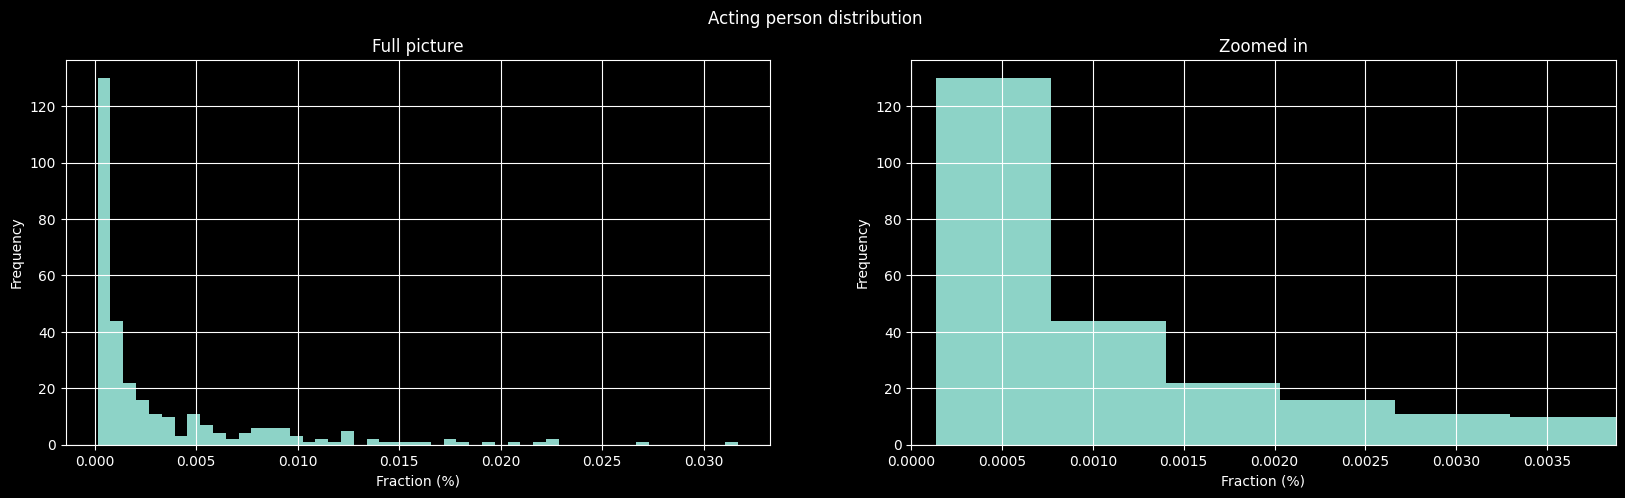

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes = iter(axes.flatten())

fig.suptitle("Acting person distribution")

ax = next(axes)
ax.set_title("Full picture")
ax.set_xlabel("Fraction (%)")
ax.set_ylabel("Frequency")
ax.hist(acting_person_distribution, bins=50)

ax = next(axes)
ax.set_title("Zoomed in")
ax.set_xlabel("Fraction (%)")
ax.set_ylabel("Frequency")
x_max = np.percentile(acting_person_distribution, 75)
ax.set_xlim([0, x_max])
ax.hist(acting_person_distribution, bins=50)

plt.show()

As we can see from the chart above most of the time only small number of acting persons have replicas and most of the acting persons appear only occasionally:
75 % of all acting persons appear only 0.35% of time.

## 2.2. Distribution of characters and words in replicas

In this section I want to see statistics of number of characters and words in replicas such as minimum, maximum and mean number + in addition plot charts of distributions.

In [8]:
dataset_df["replica_length_char"] = dataset_df["replica"].str.len()
dataset_df["replica_length_word"] = dataset_df["replica"].str.split(" ").apply(len)

In [9]:
get_stats = lambda x: (x.min(), x.max(), x.mean().astype(int))

print("Statistic of:")
print("characters -> min={:2d}, max={:4d}, mean={:3d}".format(*get_stats(dataset_df["replica_length_char"])))
print("words      -> min={:2d}, max={:4d}, mean={:3d}".format(*get_stats(dataset_df["replica_length_word"])))

Statistic of:
characters -> min= 0, max=2995, mean=137
words      -> min= 1, max= 578, mean= 26


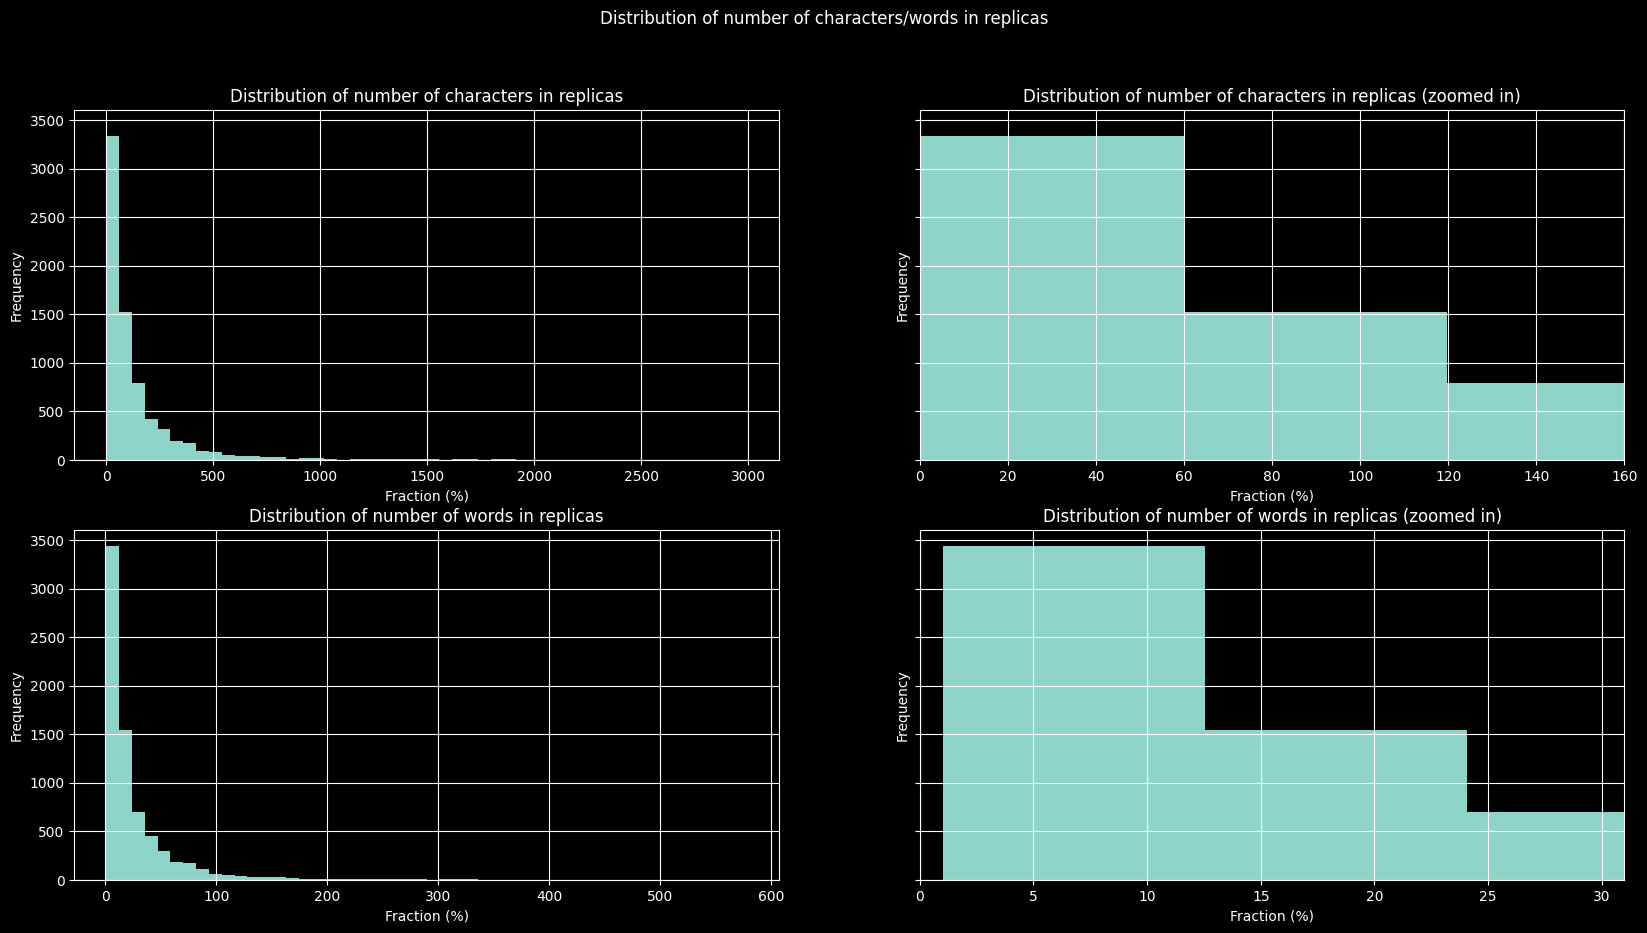

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10), sharey=True)
axes = iter(axes.flatten())

fig.suptitle("Distribution of number of characters/words in replicas")

for title, data in zip(
    ["Distribution of number of characters in replicas", "Distribution of number of words in replicas"],
    [dataset_df["replica_length_char"], dataset_df["replica_length_word"]],
):

    ax = next(axes)

    ax.set_title(title)
    ax.set_xlabel("Fraction (%)")
    ax.set_ylabel("Frequency")
    ax.hist(data, bins=50)

    ax = next(axes)

    ax.set_title(f"{title} (zoomed in)")
    ax.set_xlabel("Fraction (%)")
    ax.set_ylabel("Frequency")
    x_max = np.percentile(data, 75)
    ax.set_xlim([0, x_max])
    ax.hist(data, bins=50)

plt.show()

From the charts and statistics above we can notice that the majority of all replicas are short both in terms of characters and words: 75% of all replicas have around 160 characters and 30 words.

### 2.2.1. Most popular characters and words

In [11]:
char_counter = Counter()
word_counter = Counter()

for row in dataset_df.itertuples():
    char_counter.update(row.replica)
    word_counter.update(row.replica.split(" "))

In [12]:
print(f"Total number of unique characters: {len(char_counter)}")
print(f"Total number of unique words: {len(word_counter):,}")

Total number of unique characters: 64
Total number of unique words: 22,796


There are 64 unique characters and 22k+ words. Let's take a look and 20 most frequent characters and words.

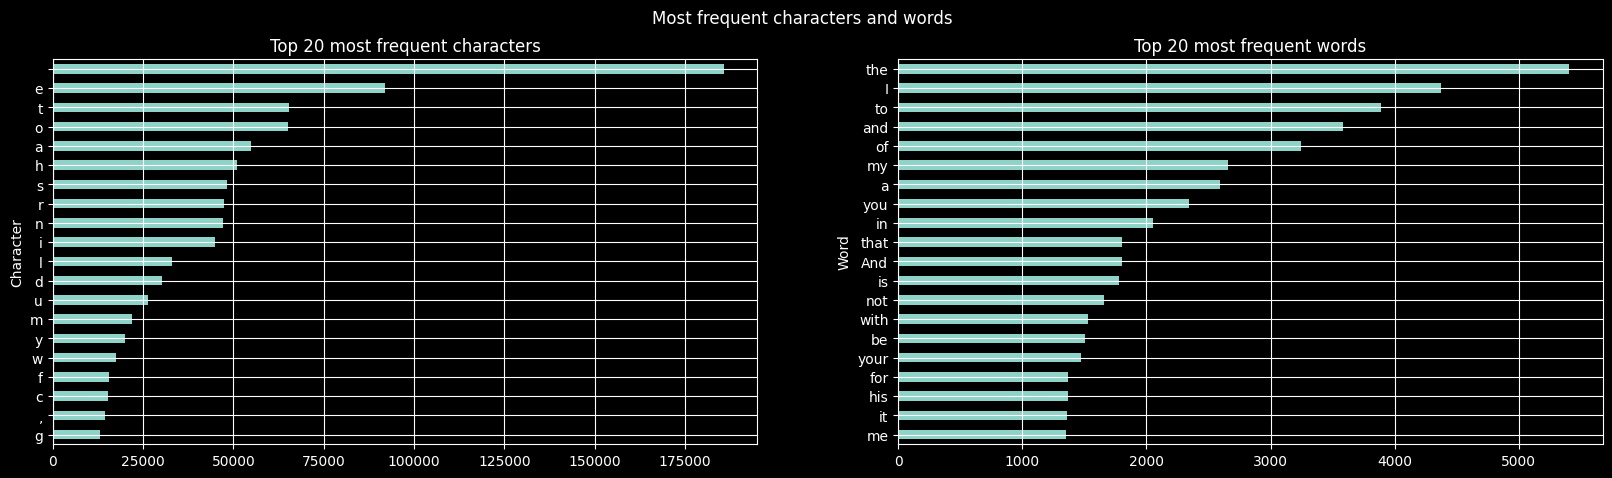

In [13]:
show_top_n = 20

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes = iter(axes.flatten())

fig.suptitle("Most frequent characters and words")

ax = next(axes)
ax.set_title(f"Top {show_top_n} most frequent characters")
ax.set_xlabel("Frequency")
ax.set_ylabel("Character")
idx, values = zip(*char_counter.most_common(show_top_n))
pd.Series(values, idx).sort_values().plot(kind="barh", ax=ax)


ax = next(axes)
ax.set_title(f"Top {show_top_n} most frequent words")
ax.set_xlabel("Frequency")
ax.set_ylabel("Word")
idx, values = zip(*word_counter.most_common(show_top_n))
pd.Series(values, idx).sort_values().plot(kind="barh", ax=ax)

plt.show()

It comes to no surprise but the most popular words are so called 'stop words'. We can assume that the generative model will not have any troubles with these words.

In addition I want to see 20 least common words (to know where the model may struggle):

In [14]:
sorted(word_counter, key=word_counter.get)[:20]

['Resolved.',
 "know't,",
 'accounted',
 'surfeits',
 'superfluity,',
 'wholesome,',
 'relieved',
 'humanely',
 'dear:',
 'afflicts',
 'inventory',
 'particularise',
 'abundance;',
 'pikes,',
 'rakes:',
 'bread,',
 'commonalty',
 'fort,',
 'maliciously',
 'famously,']

<div class="alert alert-block alert-info"><b>Preprocessing info</b>: these words above might be least common because they have punctuation signs at the end. Preprocessing should fix that.</div>

## 2.3. Distribution of replicas per acting person

As a fun part in the end I want to see which acting person has the most words/characters on average (in replicas):

In [15]:
(
    dataset_df.groupby("acting_person")
    .agg(replica_words_avg=("replica_length_word", "mean"), replica_chars_avg=("replica_length_char", "mean"))
    .astype(int)
    .sort_values(by=["replica_words_avg", "replica_chars_avg"], ascending=False)
    .iloc[:20]
)

,replica_words_avg,replica_chars_avg
acting_person,,
Time,266,1343
Scrivener,117,612
DUCHESS,113,626
Chorus,113,596
Third Gentleman,98,524
NURSE,87,440
THOMAS MOWBRAY,81,416
BISHOP OF CARLISLE,80,439
RICHMOND,76,412


Funny enough that some not-so-important acting persons like 'Third Gentleman' or 'Nurse' are at the top of the list...

In [16]:
acting_person_distribution[["Third Gentleman", "NURSE"]] * 100

Third Gentleman    0.083079
NURSE              0.013847
Name: acting_person, dtype: float64

... even though these two acting persons appear only 0.083% and 0.013% of time.